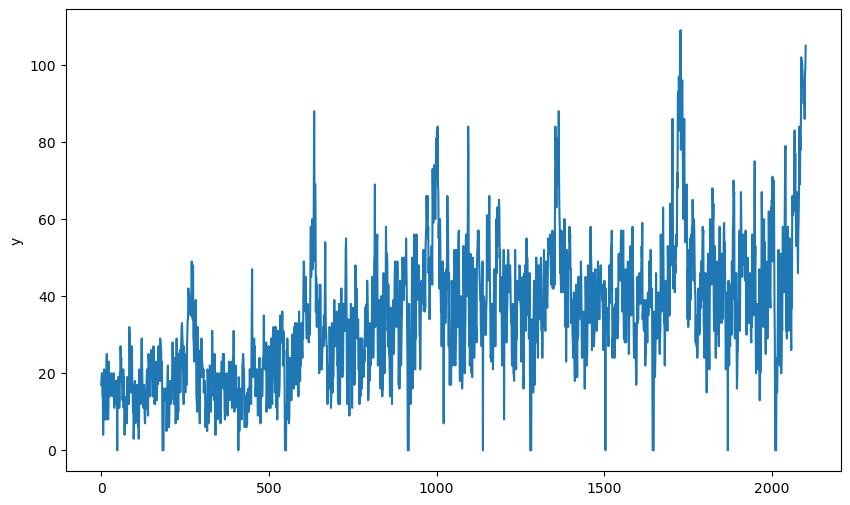

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
df = pd.read_csv('train.csv')
df.head()

df['datetime'] = pd.to_datetime(df['datetime'])
plt.figure(figsize=(10,6))
sns.lineplot(x=df.index, y="y", data=df)
plt.show()

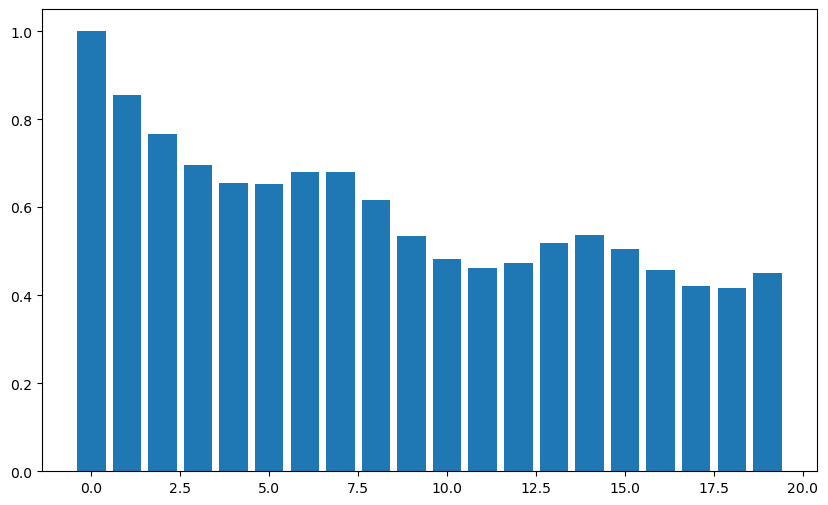

In [25]:
lags = 20
autocorrs = [df['y'].autocorr(lag=lag) for lag in range(lags)]
plt.figure(figsize=(10,6))
plt.bar(range(lags), autocorrs)
plt.show()



<Figure size 1000x600 with 0 Axes>

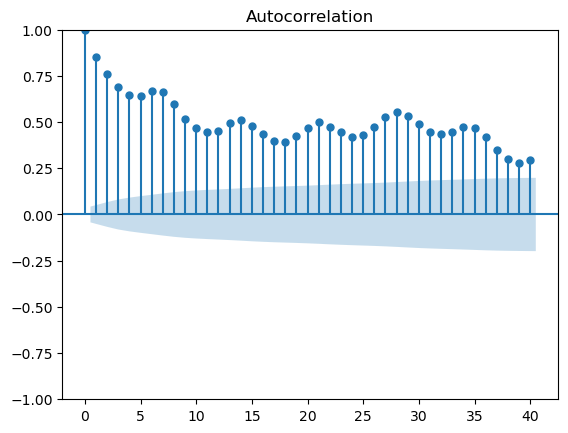

In [28]:
from statsmodels.graphics.tsaplots import plot_acf

# データの準備
df = df.sort_values("datetime").reset_index()

#コレログラムの作成
plt.figure(figsize=(10,6))
plot_acf(df['y'], lags=40)

plt.show()

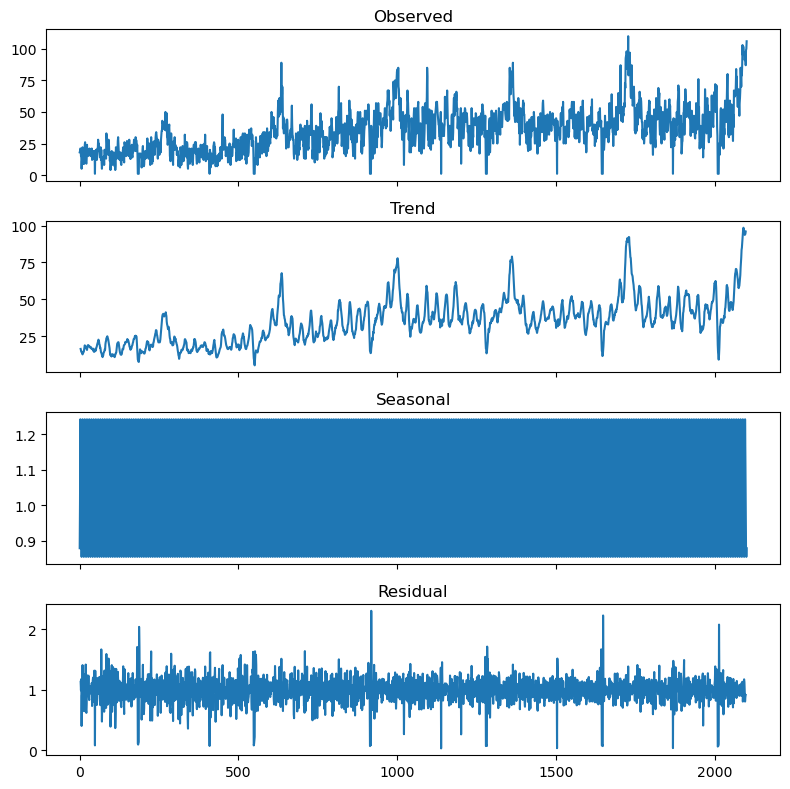

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

# データの準備
#df = df.sort_values("datetime").reset_index()
df['y'] = df['y'] + 1

# 成分分解
decompose_result = seasonal_decompose(df['y'],model='multiplicative',period=7)

# 描画領域を1列4行で設定
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(8, 8), sharex=True)

# 原系列
axes[0].set_title('Observed')
axes[0].plot(decompose_result.observed)

# 傾向変動
axes[1].set_title('Trend')
axes[1].plot(decompose_result.trend)

# 季節変動
axes[2].set_title('Seasonal')
axes[2].plot(decompose_result.seasonal)

# 残差 (不規則変動 = 誤差変動 + 特異的変動)
axes[3].set_title('Residual')
axes[3].plot(decompose_result.resid)

# グラフを表示する
plt.tight_layout()
plt.show()

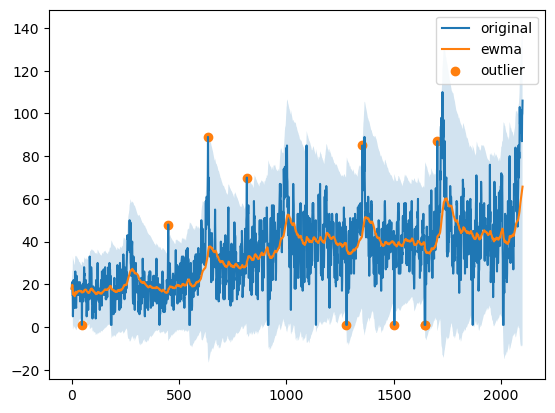

In [35]:
def plot_outlier(ts, ewm_span=90, threshold=3.0):

    fig, ax = plt.subplots()
    # 指数加重移動平均の算出
    ewm_mean = ts.ewm(span=ewm_span).mean()  
    # 指数加重移動標準偏差の算出
    ewm_std = ts.ewm(span=ewm_span).std()  
    ax.plot(ts, label='original')
    ax.plot(ewm_mean, label='ewma')

    # 標準偏差から 3.0 倍以上外れているデータを外れ値としてプロットする
    ax.fill_between(ts.index,
                    ewm_mean - ewm_std * threshold,
                    ewm_mean + ewm_std * threshold,
                    alpha=0.2)
    outlier = ts[(ts - ewm_mean).abs() > ewm_std * threshold]
    ax.scatter(outlier.index, outlier, label='outlier')
    ax.legend()
    plt.show()
    return fig,outlier

fig,out_fil = plot_outlier(df['y'],ewm_span=90, threshold=3.0);

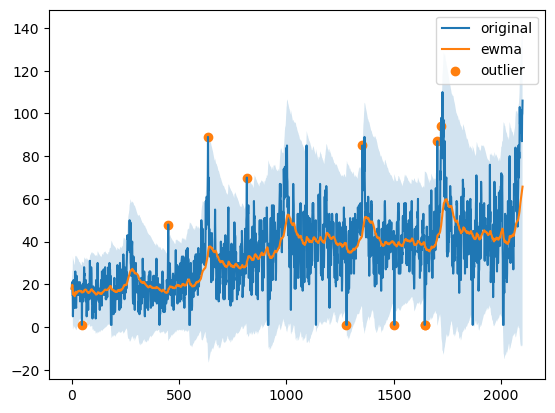

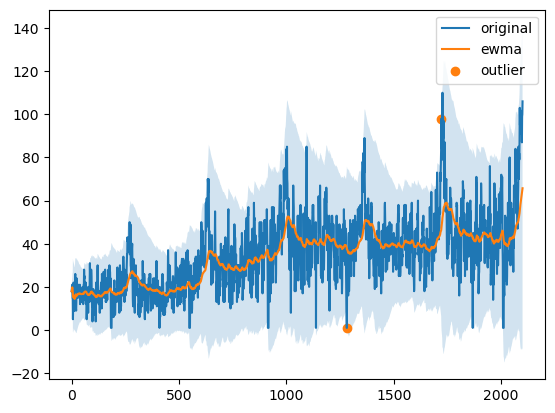

In [37]:
# 外れ値を持たないレコードを抽出
df_new = df[~df.index.isin(out_fil.index)]
fig,out_fil = plot_outlier(df_new['y'],ewm_span=90, threshold=3.0);
df_new2 = df_new[~df_new.index.isin(out_fil.index)]
fig,out_fil = plot_outlier(df_new2['y'],ewm_span=90, threshold=3.0);

In [40]:
import statsmodels.api as sm
import warnings
warnings.simplefilter('ignore')
sarima = sm.tsa.statespace.SARIMAX(df['y'],order=(1, 1, 3),seasonal_order=(0, 2, 2, 12)).fit()
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 2101
Model:             SARIMAX(1, 1, 3)x(0, 2, [1, 2], 12)   Log Likelihood               -7562.133
Date:                                 Sat, 19 Aug 2023   AIC                          15138.265
Time:                                         02:29:06   BIC                          15177.733
Sample:                                              0   HQIC                         15152.729
                                                - 2101                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5594      0.059      9.409      0.000       0.443       0.676
ma.L1         -0.8634      0.062    -14.025      0.000      -0.984      -0.743
ma.L2          0.0312      0.032      0.989      0.323      -0.031       0.093
ma.L3         -0.0737      0.033     -2.239      0.025      -0.138      -0.009
ma.S.L12      -1.9987      0.184    -10.857      0.000      -2.360      -1.638
ma.S.L24       0.9992      0.184      5.434      0.000       0.639       1.360
sigma2        77.5402     14.279      5.430      0.000      49.553     105.527
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               191.84
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.39   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
# 総当りで探索
max_p = 3
max_q = 3
max_d = 1
max_sp = 2
max_sq = 2
max_sd = 2

pattern = max_p*(max_q + 1)*(max_d + 1)*(max_sp + 1)*(max_sq + 1)*(max_sd + 1)
modelSelection = pd.DataFrame(index=range(pattern), columns=["order","season","aic"])

# 自動SARIMA選択
num = 0

for p in range(1, max_p + 1):
    for d in range(0, max_d + 1):
        for q in range(0, max_q + 1):
            for sp in range(0, max_sp + 1):
                for sd in range(0, max_sd + 1):
                    for sq in range(0, max_sq + 1):
                        sarima = sm.tsa.SARIMAX(
                            df_new2['y'], order=(p,d,q), 
                            seasonal_order=(sp,sd,sq,12), 
                            enforce_stationarity = False, 
                            enforce_invertibility = False
                        ).fit()

                        modelSelection.iloc[num]["order"] = (p, d, q)
                        modelSelection.iloc[num]["season"] = (sp, sd, sq)
                        modelSelection.iloc[num]["aic"] = sarima.aic
                        num = num + 1
print(modelSelection[modelSelection.aic == min(modelSelection.aic)])

         order     season           aic
536  (3, 0, 3)  (2, 1, 2)  14374.295735


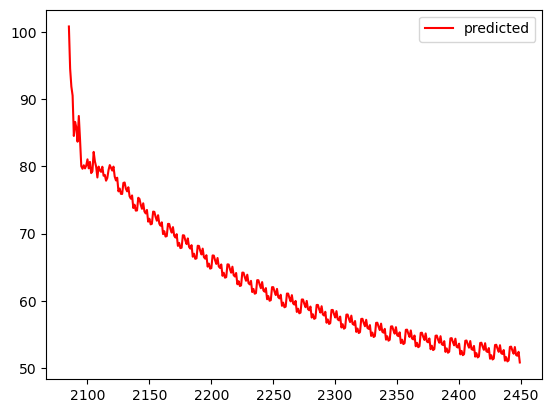

2085    100.781327
2086     94.506403
2087     91.845779
2088     90.507768
2089     84.509393
           ...    
2445     53.131589
2446     51.945833
2447     51.834715
2448     52.424955
2449     50.838846
Name: predicted_mean, Length: 365, dtype: float64
            client  close  price_am  price_pm     predict
datetime                                                 
2016-04-01       1      0         3         2  100.781327
2016-04-02       0      0         5         5   94.506403
2016-04-03       1      0         2         2   91.845779
2016-04-04       1      0         1         1   90.507768
2016-04-05       0      0         1         1   84.509393
...            ...    ...       ...       ...         ...
2017-03-27       0      0         5         4   53.131589
2017-03-28       0      0         4         4   51.945833
2017-03-29       0      0         3         3   51.834715
2017-03-30       0      0         4         3   52.424955
2017-03-31       1      0         5         4

In [74]:
df_test = pd.read_csv('test.csv')
df_test.head()
df_test['datetime'] = pd.to_datetime(df_test['datetime'])
#df_test = df_test.sort_values("datetime").reset_index()
df_test.set_index('datetime')

# SARIMAモデルの作成
#sarima = sm.tsa.statespace.SARIMAX(df_new2['y'],order=(3, 0, 3) ,seasonal_order=(2, 1, 2, 12)).fit()

# 実データと予測結果の図示
predict_result = sarima.forecast(len(df_test))
plt.plot(predict_result, label='predicted', color='red')
plt.legend(loc='best')
plt.show()
result = pd.DataFrame(df_test)
result['predict'] = list(predict_result)
result.set_index(keys='datetime', inplace=True)
print(predict_result)
print(result)
result.to_csv('submission.csv', columns=['predict'], index=True, header=False)